# U-net Paper Replication

- Original Paper: https://arxiv.org/abs/1505.04597

In [1]:
!nvidia-smi

Thu May  9 17:13:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.05              Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8              13W / 285W |   1269MiB / 12282MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torchvision
from torchvision import transforms

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [3]:
import os
import sys
from pathlib import Path

sys.path.insert(0, str(Path(os.getcwd()).parent))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [5]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 512)
TRAIN_SPLIT = 0.7
NUM_WORKERS = 2

SEED = 42

## 01. Data

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import src.data.transforms as transforms_custom
from src.data.dataset import DATASET_NAME
from src.data.dataloader import get_dataloaders


transform_train = A.Compose(
    [
        A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
        A.ToGray(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

transform_test = A.Compose(
    [
        A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_dataloader, test_dataloader = get_dataloaders(
    dataset=DATASET_NAME.CITYSCAPES,
    root=Path("/home/geri/projects/machine_learning/datasets/cityscapes"),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform_train=transform_train,
    transform_test=transform_test,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 255.5, -0.5)

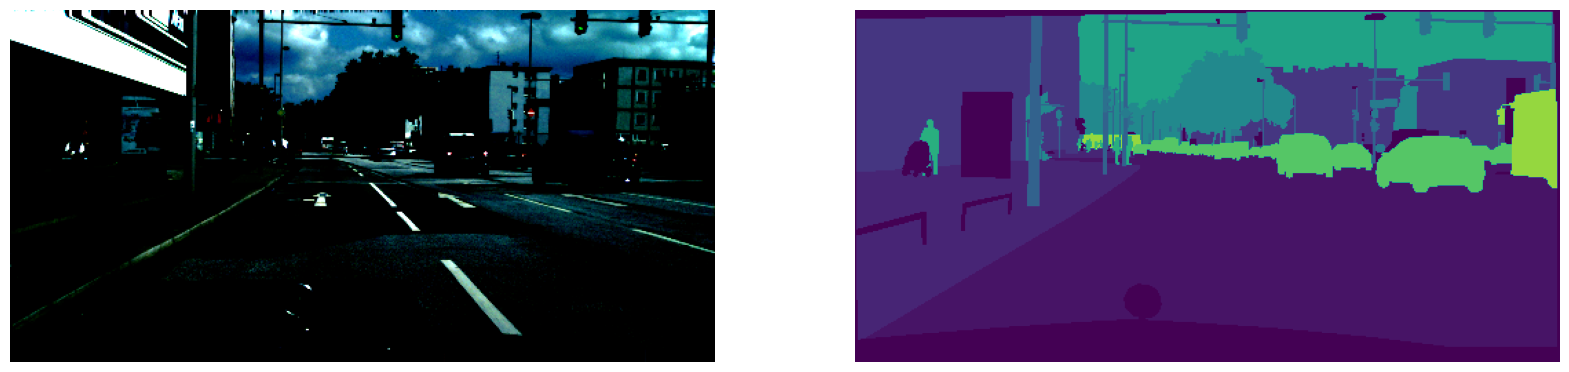

In [7]:
import matplotlib.pyplot as plt

img, target = next(iter(train_dataloader))

fig = plt.figure(figsize=(20, 30))

fig.add_subplot(1, 2, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.axis(False)

fig.add_subplot(1, 2, 2)
plt.imshow(target[0])
plt.axis(False)

In [19]:
import numpy as np

print(f"Image Size: {img[0].shape}\tTarget Size: {target[0].shape}")
print(f"Labels in target image: {np.unique(target[0])}")

Image Size: torch.Size([1024, 2048, 3])	Target Size: torch.Size([1024, 2048])
Labels in target image: [ 0  1  2  3  6  7  8  9 11 12 14]


## 02. Model

In [20]:
from src.models.unet.unet import UNet
from torchinfo import summary

model = UNet()

summary(
    model,
    input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                                   [1, 3, 512, 512]     [1, 1, 512, 512]     --                   True
├─Encoder (encoder)                           [1, 3, 512, 512]     [1, 512, 32, 32]     --                   True
│    └─ModuleList (layers)                    --                   --                   (recursive)          True
│    │    └─DoubleConv (0)                    [1, 3, 512, 512]     [1, 64, 512, 512]    38,848               True
│    └─MaxPool2d (pool)                       [1, 64, 512, 512]    [1, 64, 256, 256]    --                   --
│    └─ModuleList (layers)                    --                   --                   (recursive)          True
│    │    └─DoubleConv (1)                    [1, 64, 256, 256]    [1, 128, 256, 256]   221,696              True
│    └─MaxPool2d (pool)                       [1, 128, 256, 256]   [1, 128, 128, 128]

## 03. Train

In [33]:
from torch import nn

EPOCHS = 50

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=10e-4)

In [34]:
from src.models.train import train

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=None,
    optimizer=None,
    epochs=EPOCHS,
    device=device,
    writer=None,
)

  0%|          | 0/50 [00:00<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/geri/.venv/computer_vision/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/geri/.venv/computer_vision/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/geri/.venv/computer_vision/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/geri/work/unet_replication/src/data/dataset.py", line 27, in __getitem__
    try:
  File "/home/geri/.venv/computer_vision/lib/python3.10/site-packages/PIL/Image.py", line 3277, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/geri/work/unet_replication/data/VOC2012/JPEGImages/2011_000999.png'
